We perform an l-1 regression analysis with feature vectors as miRNA expressions and targets as pathologic stage mapped to numbers 1 to 9

In [25]:
import os
import pandas

mirna_src_dir = os.getcwd() + "/assn-mirna-luad/data/processed/mirna/"
clinical_src_dir = os.getcwd() + "/assn-mirna-luad/data/processed/clinical/"

mirna_df = pandas.read_csv(mirna_src_dir+'mirna.csv')
clinical_df = pandas.read_csv(clinical_src_dir+'clinical.csv')

"""
Here we select samples to use for our regression analyss
"""
matched_samples = pandas.merge(clinical_df, mirna_df, on='patient_barcode').dropna(subset=['pathologic_stage', 'hsa-mir-96'])['patient_barcode']
print "matched_samples", matched_samples.shape
merged = pandas.merge(clinical_df, mirna_df, on='patient_barcode')

print merged['histological_type'].value_counts().sort_index(axis=0)
print merged['pathologic_stage'].value_counts().sort_index(axis=0)
print merged['pathologic_T'].value_counts().sort_index(axis=0)
print merged['pathologic_N'].value_counts().sort_index(axis=0)
print merged['pathologic_M'].value_counts().sort_index(axis=0)

matched_samples (505,)
Lung Acinar Adenocarcinoma                             18
Lung Adenocarcinoma Mixed Subtype                     106
Lung Adenocarcinoma- Not Otherwise Specified (NOS)    320
Lung Bronchioloalveolar Carcinoma Mucinous              5
Lung Bronchioloalveolar Carcinoma Nonmucinous          19
Lung Clear Cell Adenocarcinoma                          2
Lung Micropapillary Adenocarcinoma                      2
Lung Mucinous Adenocarcinoma                            2
Lung Papillary Adenocarcinoma                          23
Lung Signet Ring Adenocarcinoma                         1
Lung Solid Pattern Predominant Adenocarcinoma           5
Mucinous (Colloid) Carcinoma                           10
Name: histological_type, dtype: int64
Stage I         5
Stage IA      133
Stage IB      139
Stage II        1
Stage IIA      50
Stage IIB      70
Stage IIIA     73
Stage IIIB     11
Stage IV       24
Name: pathologic_stage, dtype: int64
T1      67
T1a     48
T1b     55
T2     165


Do a simple miRNA feature selection with target values as the pathologic stage mapped to number range 1-9

In [26]:
pathologic_stage_map = {'Stage I': 1, 'Stage IA': 1, 'Stage IB': 1, 
                        'Stage II': 3, 'Stage IIA': 3, 'Stage IIB': 3, 
                        'Stage IIIA': 6, 'Stage IIIB': 6, 
                        'Stage IV': 10}
pathologic_t_map = {'T1': 2, 'T1a': 1, 'T1b': 3, 'T2': 6, 'T2a': 5, 'T2b': 8, 'T3': 11, 'T4': 18, 'TX': 0}
pathologic_N_map = {'N0': 0, 'N1': 2, 'N2': 5, 'N3': 9, 'NX': 0}

clinical_df.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

Prepare training & testing data

In [15]:
from sklearn import preprocessing

X = mirna_df[mirna_df['patient_barcode'].isin(matched_samples)]
X.__delitem__('patient_barcode')
Y = clinical_df[clinical_df['patient_barcode'].isin(matched_samples)]['pathologic_stage']
print 'miRNA null values', X.isnull().sum().sum()
print 'X.shape', X.shape
print 'Y.shape', Y.shape
mirna_list = X.columns.values

X = preprocessing.scale(X)
Y = preprocessing.scale(Y)

miRNA null values 0
X.shape (505, 1881)
Y.shape (505,)


Perform LASSO feature selection with cross-validation to find best model

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print 'X_train.shape', X_train.shape
print 'X_test.shape', X_test.shape

model = linear_model.LassoCV(cv=3, fit_intercept=False, n_jobs=-1)
print model.fit(X_train, y_train)

print "\nMSE train:", mean_squared_error(y_train, model.predict(X=X_train))
print "MSE test:", mean_squared_error(y_test, model.predict(X=X_test))

print "\nNon-zero coef:", np.nonzero(model.coef_)[0].size
print mirna_list[np.nonzero(model.coef_)[0]]
print model.coef_[np.nonzero(model.coef_)[0]]
# plt.hist(model.coef_, bins=100)
# plt.show()

X_train.shape (404, 1881)
X_test.shape (101, 1881)


LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

MSE train: 0.908507463039
MSE test: 1.36597014784

Non-zero coef: 0
[]
[]


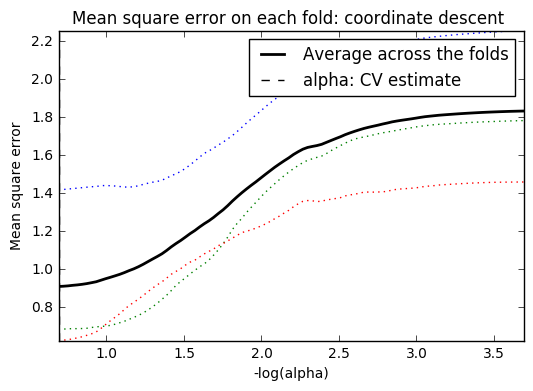

In [21]:
from matplotlib import pyplot as plt
# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.show()

[ 0.  0.  0.  0.  0.  0.]
[-0.59643133 -0.59643133 -0.59643133  3.43746805 -0.59643133 -0.59643133]


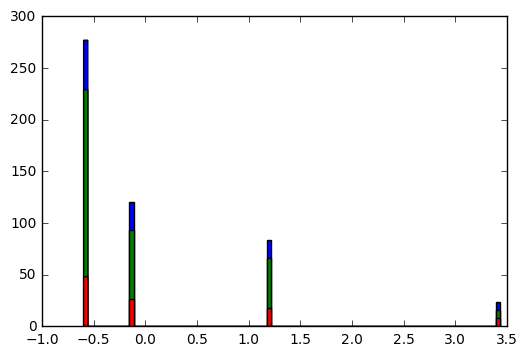

In [23]:
print model.predict(X=X_train)[0:6]
print y_train[0:6]
plt.hist(Y, bins=100, label="Original Y")
plt.hist(y_train - model.predict(X=X_train), bins=100, label="Train error")
plt.hist(y_test - model.predict(X=X_test), bins=100, label='Test error')
plt.show()